In [1]:
import sys
sys.path.insert(0,'../environments/'); import gw
sys.path.insert(0,'../environments/'); import gridworld_plotting as gp

import pickle
import numpy as np

import matplotlib.pyplot as plt
from importlib import reload

from scipy.stats import entropy

import imageio
from os import listdir
from os.path import isfile, join


# to do 
def make_figs(figure_data, fig_type, savedir, **kwargs):
    start_ind = kwargs.get('start_ind', 0)
    last_ind = kwargs.get('last_ind', len(figure_data))
    show = kwargs.get('showfig', False)
    switch_ind = kwargs.get('switch_ind', int(len(figure_data)/2))
    reward_location = kwargs.get('reward_location', (10,3))
    
    if fig_type == 'P':
        print(start_ind, last_ind)
        for ind, obj in enumerate(figure_data[start_ind:last_ind]):
            print(ind)
            gp.plot_polmap(env,obj,
                           save=True,
                           show=show, 
                           directory=savedir,
                           title = f'Policy @ trial {ind}', 
                           rwds=[reward_location],threshold = .3)
    elif fig_type == 'V':
        v_range = kwargs.get('v_range', [0,1])
        for ind, obj in enumerate(figure_data[start_ind:last_ind]):
            gp.plot_valmap(env,obj,v_range = v_range,
                           save=True,
                           show=show, 
                           directory=savedir,
                           title = f'Value @ trial {ind}', 
                           rwds=[reward_location])
        

def make_gif(source_directory, target_directory, save_title, **kwargs):
    ## works with all images in a directory
    duration = kwargs.get('dur',0.1)
    filenames = [f for f in listdir(source_directory) if isfile(join(source_directory,f))]
    
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    
    imageio.mimsave(f'{target_directory}{save_title}.gif', images, duration = duration)


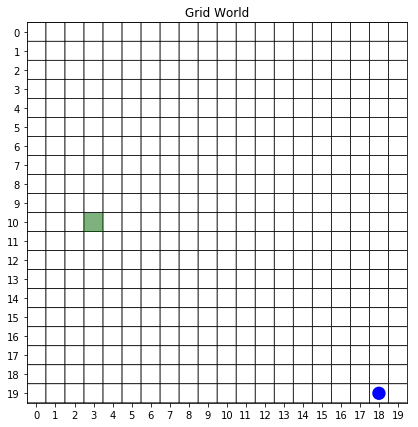

In [2]:
rows, columns = 20, 20
env = gw.GridWorld(rows=rows,cols=columns,rewards = {(10,3):1},step_penalization=-0.01)
fig = gw.plotWorld(env,current_state=True,scale=0.35)

#fig.savefig('../Blake Meeting/10-3.svg', format='svg')

In [18]:
#data = pickle.load(open('../Blake Meeting/simple_network/MF_only_alltrials.p','rb'))
#data = pickle.load(open('../Blake Meeting/simple_network/MF_only_calc_switch.p','rb'))
MF__ = pickle.load(open('../Blake Meeting/simple_network/MF__.p', 'rb'))
MFEC = pickle.load(open('../Blake Meeting/simple_network/MF_EC.p','rb'))
fail = pickle.load(open('../Blake Meeting/simple_network/MF_ECfail.p','rb'))
##[0:101] + [t+5000 for t in data['t'][101:]]

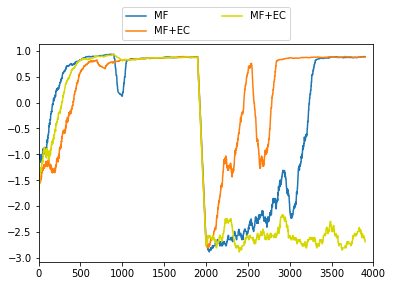

In [26]:
smoothing = 100

plt.plot(gp.running_mean(MF__['total_reward'], smoothing), alpha=1, label = 'MF')
plt.plot(gp.running_mean(MFEC['total_reward'], smoothing), alpha=1, label = 'MF+EC')
plt.plot(gp.running_mean(fail['total_reward'], smoothing), alpha=1, label = 'MF+EC', color=(215/255,215/255,0/255))
plt.legend(bbox_to_anchor=(0.25, 1.02, 0.5, .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlim([0,4000])
plt.savefig('../Blake Meeting/reward_smoothed100.svg', format='svg')

# Make Gif

In [ ]:
ec_data = data['ec_tracking']
ec_savedir = '../Blake Meeting/p_figs/'
ec_figtype = 'P'
make_figs(ec_data, ec_figtype, ec_savedir)

In [ ]:
duration = 0.05
start_ind = 2950
last_ind = 3201
directory = './Blake Meeting/simple_network/every_trial/'

In [ ]:
savedir = './Blake Meeting/p_figs/'
for ind, obj in enumerate(data['pol_tracking'][start_ind:last_ind]):
    if times[ind]+start_ind < len(times)/2:
        gp.plot_polmap(env,obj,save=True,show=False, directory=savedir, title = times[ind]+start_ind, rwds=[(10,3)])
    else:
        gp.plot_polmap(env,obj,save=True,show=False, directory=savedir, title = times[ind]+start_ind, rwds=[(10,16)])


In [ ]:
filenames = [f for f in listdir(savedir) if isfile(join(savedir,f))]

p_files = []
for f in filenames:
    p_files.append(f)

p_images = []

for i in range(len(times[start_ind:last_ind-1])):
    filename = savedir+f'{times[i]+start_ind}.png'
    p_images.append(imageio.imread(filename))
imageio.mimsave(f'{directory}pol_evol{start_ind}-{last_ind}.gif', p_images, duration = duration)

In [ ]:
savedir = './Blake Meeting/v_figs/'
for ind, obj in enumerate(data['val_tracking'][start_ind:last_ind]):
    if times[ind]+start_ind < len(times)/2:
        gp.plot_valmap(env,obj,save=True,show=False, directory=savedir, title = times[ind]+start_ind, rwds=[(10,3)])
    else:
        gp.plot_valmap(env,obj,save=True,show=False, directory=savedir, title = times[ind]+start_ind, rwds=[(10,16)])

In [ ]:
duration = 0.2
filenames = [f for f in listdir(savedir) if isfile(join(savedir,f))]
v_files = []
for f in filenames:
    v_files.append(f)
    
v_images = []
for i in range(len(p_files)-1):
    filename = savedir+f'{times[i]+start_ind}.png'
    v_images.append(imageio.imread(filename))
imageio.mimsave(f'{directory}val_evol{start_ind}-{last_ind}.gif', v_images, duration = duration)

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(data['trial_length'])
ax[1].plot(data['loss'][0], label='p')
ax[1].plot(data['loss'][1], label='v')
ax[1].legend(loc=0)
plt.show()
#plt.savefig('./Blake Meeting/extended_network/MF_only_reward.svg', format='svg')

# KLD analysis

In [29]:
MF_ps = MF__['pol_tracking']

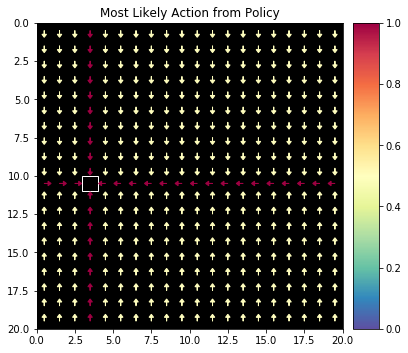

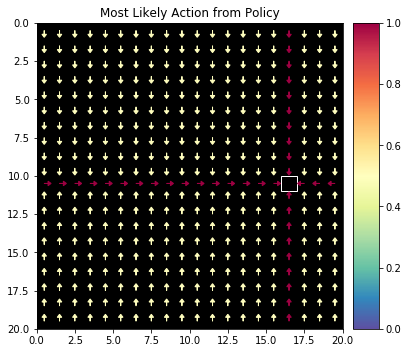

In [30]:
training_reward = (10,3)
testing_reward  = (10,16)

def softmax(x, T=1):
    e_x = np.exp((x - np.max(x))/T)
    return e_x / e_x.sum(axis=0)

def optimal_policy(reward_location):    
    reward_r, reward_c = reward_location
    pol_array = np.zeros(env.grid.shape, dtype=[('N', 'f8'), ('E', 'f8'), ('W', 'f8'), ('S', 'f8'), ('stay', 'f8'), ('poke', 'f8')])
    mag = 100
    for i in range(pol_array.shape[0]):  # rows
        for j in range(pol_array.shape[1]):  # columns
            # D: N
            # U: S
            # L: W
            # R: E
            if i < reward_r:
                D = mag
                U = 0
            elif i > reward_r:
                D = 0
                U = mag
            else:
                D = 0
                U = 0
                
            
            if j < reward_c:
                R = mag
                L = 0
                
            elif j > reward_c:
                R = 0
                L = mag
            else:
                R = 0
                L = 0
            stay = 0
            poke = 0
            #if i == reward_r and j == reward_c:
            #    poke = mag

            actions = [D, U, R, L, stay, poke]
            policy = softmax(actions,T=1.1)
            pol_array[i][j] = tuple(policy)
    
    return pol_array

opt_training = optimal_policy(training_reward)
opt_testing = optimal_policy(testing_reward)
gp.plot_polmap(env,opt_training, rwds=[training_reward] )
gp.plot_polmap(env,opt_testing, rwds=[testing_reward] )

In [32]:
kld_average = []
kld_training = []
times = MF__['t']
for i in range(0, int(len(times)/2)):
    
    kld = np.zeros(opt_training.shape)
    
    for j in range(kld.shape[0]):
    
        for k in range(kld.shape[1]):
                x = MF_ps[i][j,k].tolist()
                y = opt_training[j,k].tolist()

                kld[j,k] = entropy(x,y)
    kld_average.append(np.mean(kld))
    kld_training.append(kld)

In [33]:
kld_testing = []

for i in range(int(len(times)/2),len(times)):
    
    kld = np.zeros(opt_testing.shape)
    
    for j in range(kld.shape[0]):
    
        for k in range(kld.shape[1]):
                x = MF_ps[i][j,k].tolist()
                y = opt_testing[j,k].tolist()

                kld[j,k] = entropy(x,y)
    kld_average.append(np.mean(kld))
    kld_testing.append(kld)

In [35]:
sample_size = 10
show=False
save=True
directory = '../Blake Meeting/kld_figs/'

for i in range(0,len(kld_training),sample_size):
    gp.plot_valmap(env, kld_training[i], rwds=[training_reward], v_range=[0,100],show=show, save=save, directory=directory,title=f'train{i}')
    
for i in range(0,len(kld_testing),sample_size):
    gp.plot_valmap(env, kld_testing[i], rwds=[testing_reward], v_range=[0,100],show=show, save=save, directory=directory,title=f'test{i}')

In [ ]:
kld_avg = []
for i in kld_training:
    kld_avg.append(np.mean(i))
    
for i in kld_testing:
    kld_avg.append(np.mean(i))

In [39]:
savedir = '../Blake Meeting/kld_figs/'
duration = 0.05
filenames = [f for f in listdir(savedir) if isfile(join(savedir,f))]
train_files = []
test_files = []
for f in filenames:
    if f[0:5] == 'train':
        train_files.append(f)
    elif f[0:4] == 'test':
        test_files.append(f)
        
kld_images = []
for i in range(len(train_files)):
    filename = savedir+f'train{i*sample_size}.png'
    kld_images.append(imageio.imread(filename))

imageio.mimsave(f'../Blake Meeting/kld_train_evol.gif', kld_images, duration = duration)

kld_images = []
for i in range(len(test_files)):
    filename = savedir+f'test{i*sample_size}.png'
    kld_images.append(imageio.imread(filename))
imageio.mimsave(f'../Blake Meeting/kld_test_evol.gif', kld_images, duration = duration)
    


## episodic kld

In [49]:

def make_kld_plots(policies):
    kld_average = []
    kld_training = []
    for i in range(0, int(len(times)/2)):

        kld = np.zeros(opt_training.shape)

        for j in range(kld.shape[0]):

            for k in range(kld.shape[1]):
                x = policies[i][j,k].tolist()
                y = opt_training[j,k].tolist()
                if sum(x)==0:
                    kld[j,k] = np.nan
                else:
                    kld[j,k] = entropy(x,y)
        kld_average.append(np.nanmean(kld))
        kld_training.append(kld)

    kld_testing = []
    for i in range(int(len(times)/2),len(times)):
        kld = np.zeros(opt_testing.shape)
        for j in range(kld.shape[0]):
            for k in range(kld.shape[1]):
                x = policies[i][j,k].tolist()
                y = opt_testing[j,k].tolist()
                if sum(x)==0:
                    kld[j,k] = np.nan
                else:
                    kld[j,k] = entropy(x,y)
        kld_average.append(np.nanmean(kld))
        kld_testing.append(kld)
    return kld_training + kld_testing, kld_average



In [54]:
MF = MF__['']
EC1 = fail['ec_tracking']
EC2 = MFEC['ec_tracking']
#mfkld, mf_a = make_kld_plots(MF)
eckld, ec_a1 = make_kld_plots(EC2)

In [46]:
kld_avg = []
for i in kld_training:
    kld_avg.append(np.nanmean(i))
    
for i in kld_testing:
    kld_avg.append(np.nanmean(i))

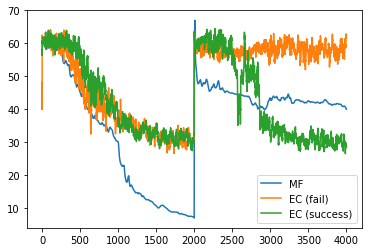

In [56]:
#plt.plot(kld_average, label='MF')
plt.plot(mf_a, label='MF')
plt.plot(ec_a, label='EC (fail)')
plt.plot(ec_a1, label='EC (success)')
plt.legend(loc=0)

# Rewards

In [ ]:
plt.plot(MF__['total_reward'])
